# DBSCAN Clustering Algorithm:
#DBSCAN is a density-based clustering algorithm that groups data points that are closely packed together and marks outliers as noise based on their density in the feature space. It identifies clusters as dense regions in the data space separated by areas of lower density. Unlike K-Means or hierarchical clustering which assumes clusters are compact and spherical, DBSCAN perform well in handling real-world data irregularities such as:

#(1)Arbitrary-Shaped Clusters: Clusters can take any shape not just circular or convex.
#(2)Noise and Outliers: It effectively identifies and handles noise points without assigning them to any cluster.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

In [43]:
# Load the Mall Customer dataset:-
data = pd.read_csv(r"C:\Users\ASUS\Desktop\cleaned_DataAnalysis\archive (11).zip")


In [44]:
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [45]:
data.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [46]:
data.shape

(200, 5)

In [47]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [48]:
# Select numerical features for clustering
X = data[['Annual Income (k$)', 'Spending Score (1-100)']].values

# Normalize for better distance calculation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [49]:
from collections import deque

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

def region_query(X, point_idx, eps):
    neighbors = []
    for i in range(len(X)):
        if euclidean_distance(X[point_idx], X[i]) <= eps:
            neighbors.append(i)
    return neighbors

def dbscan(X, eps, min_pts):
    labels = np.full(len(X), -1)  # -1 means unvisited
    cluster_id = 0
    
    for i in range(len(X)):
        if labels[i] != -1:
            continue
        
        neighbors = region_query(X, i, eps)
        
        if len(neighbors) < min_pts:
            labels[i] = -2  # mark as noise
        else:
            # start new cluster
            cluster_id += 1
            queue = deque(neighbors)
            labels[i] = cluster_id
            
            while queue:
                point = queue.popleft()
                
                if labels[point] == -2:  # noise becomes part of cluster
                    labels[point] = cluster_id
                
                if labels[point] != -1:
                    continue
                
                labels[point] = cluster_id
                
                new_neighbors = region_query(X, point, eps)
                if len(new_neighbors) >= min_pts:
                    queue.extend(new_neighbors)
    return labels

In [50]:
eps = 0.3      # radius (we can also perform tuning)
min_pts = 5     # minimum neighbors
labels = dbscan(X_scaled, eps, min_pts)

unique_clusters = set(labels)
print(f"Clusters formed (including noise): {unique_clusters}")

Clusters formed (including noise): {np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(-2)}


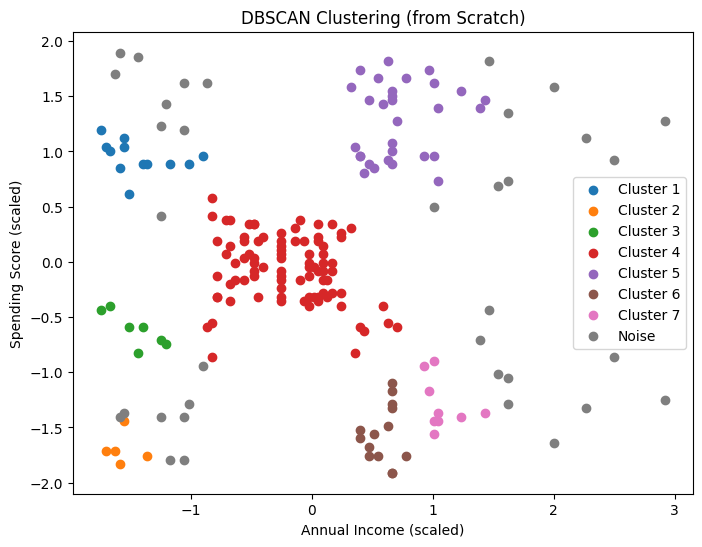

In [51]:
plt.figure(figsize=(8,6))
for cluster in set(labels):
    if cluster == -2:
        color = 'k'  # black for noise
        label = 'Noise'
    else:
        color = None
        label = f'Cluster {cluster}'
    plt.scatter(X_scaled[labels == cluster, 0],
                X_scaled[labels == cluster, 1],
                label=label)
plt.title("DBSCAN Clustering (from Scratch)")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.legend()
plt.show()

# Silhouette Score for scratch implementation:-

In [52]:
from sklearn.metrics import silhouette_score

# Remove noise points before scoring(It's important and necessary)
mask = labels != -2
if len(set(labels[mask])) > 1:   # need at least 2 clusters
    sil_score = silhouette_score(X_scaled[mask], labels[mask])
    print(f"Silhouette Score (DBSCAN Scratch): {sil_score:.3f}")
else:
    print("Silhouette score cannot be computed (only one cluster or too much noise).")

Silhouette Score (DBSCAN Scratch): 0.524


# Silhouette Optimization(To find best eps and min_samples)

In [53]:
from sklearn.metrics import silhouette_score
import numpy as np

def optimize_dbscan(X_scaled, eps_values, minpts_values):
    best_score = -1
    best_params = None
    
    for eps in eps_values:
        for min_pts in minpts_values:
            labels = dbscan(X_scaled, eps, min_pts)
            mask = labels != -2  # remove noise points
            
            # Need at least 2 clusters to compute silhouette score
            if len(set(labels[mask])) > 1:
                score = silhouette_score(X_scaled[mask], labels[mask])
                print(f"eps={eps}, minPts={min_pts} → Silhouette={score:.3f}")
                
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_pts)
            else:
                print(f"eps={eps}, minPts={min_pts} → Not enough clusters")
    
    print("\n✅ Best Parameters:")
    print(f"eps = {best_params[0]}, minPts = {best_params[1]} → Best Silhouette = {best_score:.3f}")
    return best_params

In [54]:
# Try multiple eps and minPts combinations
eps_range = np.arange(0.2, 0.6, 0.1)
minpts_range = [3, 5, 7, 10]

best_eps, best_minpts = optimize_dbscan(X_scaled, eps_range, minpts_range)

eps=0.2, minPts=3 → Silhouette=0.470
eps=0.2, minPts=5 → Silhouette=0.586
eps=0.2, minPts=7 → Silhouette=0.609
eps=0.2, minPts=10 → Not enough clusters
eps=0.30000000000000004, minPts=3 → Silhouette=0.472
eps=0.30000000000000004, minPts=5 → Silhouette=0.524
eps=0.30000000000000004, minPts=7 → Silhouette=0.645
eps=0.30000000000000004, minPts=10 → Silhouette=0.607
eps=0.4000000000000001, minPts=3 → Silhouette=0.395
eps=0.4000000000000001, minPts=5 → Silhouette=0.478
eps=0.4000000000000001, minPts=7 → Silhouette=0.495
eps=0.4000000000000001, minPts=10 → Silhouette=0.597
eps=0.5000000000000001, minPts=3 → Silhouette=0.389
eps=0.5000000000000001, minPts=5 → Silhouette=0.388
eps=0.5000000000000001, minPts=7 → Silhouette=0.394
eps=0.5000000000000001, minPts=10 → Silhouette=0.511

✅ Best Parameters:
eps = 0.30000000000000004, minPts = 7 → Best Silhouette = 0.645


In [55]:
best_labels = dbscan(X_scaled, best_eps, best_minpts)

mask = best_labels != -2
final_score = silhouette_score(X_scaled[mask], best_labels[mask])

print(f"\n🏆 Final DBSCAN Scratch Model → Silhouette Score: {final_score:.3f}")


🏆 Final DBSCAN Scratch Model → Silhouette Score: 0.645


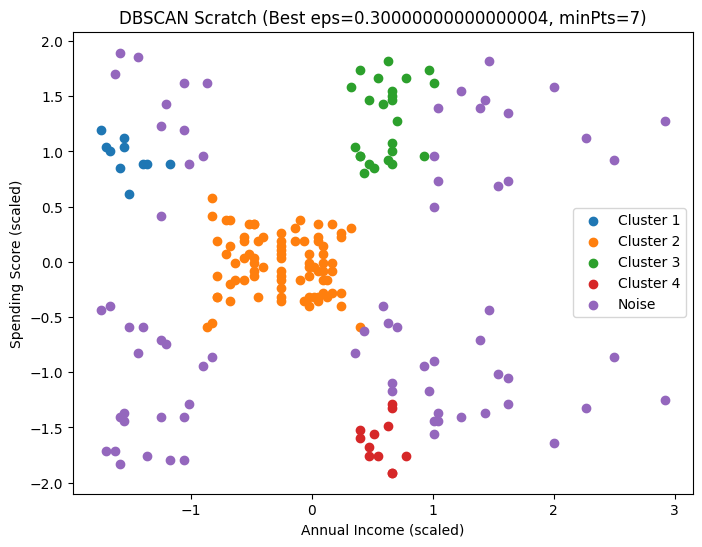

In [56]:
plt.figure(figsize=(8,6))
for cluster in set(best_labels):
    if cluster == -2:
        color = 'k'
        label = 'Noise'
    else:
        color = None
        label = f'Cluster {cluster}'
    plt.scatter(X_scaled[best_labels == cluster, 0],
                X_scaled[best_labels == cluster, 1],
                label=label)
plt.title(f"DBSCAN Scratch (Best eps={best_eps}, minPts={best_minpts})")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.legend()
plt.show()

# DBSCAN using sklearn:-

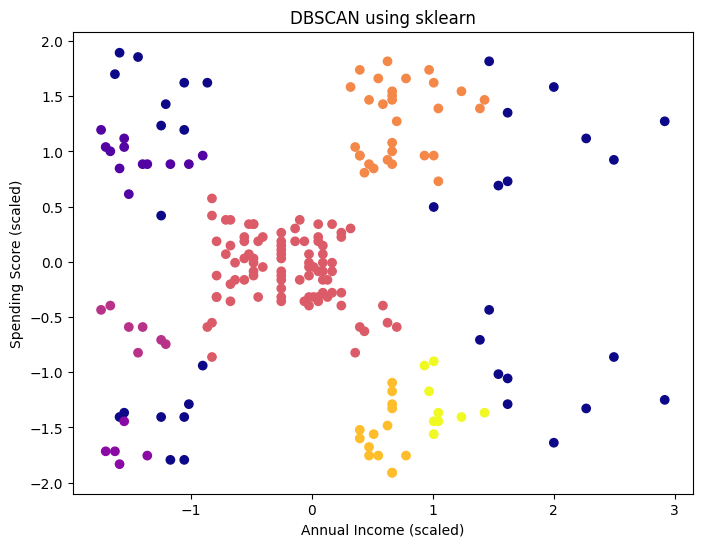

In [57]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=5)
sk_labels = db.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=sk_labels, cmap='plasma')
plt.title("DBSCAN using sklearn")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.show()

# Silhouette Optimization for sklearn implementation:

In [58]:
mask2 = sk_labels != -1
if len(set(sk_labels[mask2])) > 1:
    sil_score2 = silhouette_score(X_scaled[mask2], sk_labels[mask2])
    print(f"Silhouette Score (Sklearn DBSCAN): {sil_score2:.3f}")
else:
    print("Silhouette score cannot be computed for sklearn model.")

Silhouette Score (Sklearn DBSCAN): 0.524


In [59]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

def optimize_sklearn_dbscan(X_scaled, eps_values, minpts_values):
    best_score = -1
    best_params = None
    
    for eps in eps_values:
        for min_pts in minpts_values:
            model = DBSCAN(eps=eps, min_samples=min_pts)
            labels = model.fit_predict(X_scaled)
            
            mask = labels != -1  # remove noise
            if len(set(labels[mask])) > 1:
                score = silhouette_score(X_scaled[mask], labels[mask])
                print(f"[Sklearn] eps={eps}, minPts={min_pts} → Silhouette={score:.3f}")
                
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_pts)
            else:
                print(f"[Sklearn] eps={eps}, minPts={min_pts} → Not enough clusters")
    
    print("\n✅ Best Parameters for Sklearn DBSCAN:")
    print(f"eps = {best_params[0]}, minPts = {best_params[1]} → Best Silhouette = {best_score:.3f}")
    return best_params

In [60]:
eps_range = np.arange(0.2, 0.6, 0.1)
minpts_range = [3, 5, 7, 10]

best_eps_sklearn, best_minpts_sklearn = optimize_sklearn_dbscan(X_scaled, eps_range, minpts_range)

[Sklearn] eps=0.2, minPts=3 → Silhouette=0.470
[Sklearn] eps=0.2, minPts=5 → Silhouette=0.586
[Sklearn] eps=0.2, minPts=7 → Silhouette=0.609
[Sklearn] eps=0.2, minPts=10 → Not enough clusters
[Sklearn] eps=0.30000000000000004, minPts=3 → Silhouette=0.472
[Sklearn] eps=0.30000000000000004, minPts=5 → Silhouette=0.524
[Sklearn] eps=0.30000000000000004, minPts=7 → Silhouette=0.645
[Sklearn] eps=0.30000000000000004, minPts=10 → Silhouette=0.607
[Sklearn] eps=0.4000000000000001, minPts=3 → Silhouette=0.395
[Sklearn] eps=0.4000000000000001, minPts=5 → Silhouette=0.478
[Sklearn] eps=0.4000000000000001, minPts=7 → Silhouette=0.495
[Sklearn] eps=0.4000000000000001, minPts=10 → Silhouette=0.597
[Sklearn] eps=0.5000000000000001, minPts=3 → Silhouette=0.389
[Sklearn] eps=0.5000000000000001, minPts=5 → Silhouette=0.388
[Sklearn] eps=0.5000000000000001, minPts=7 → Silhouette=0.394
[Sklearn] eps=0.5000000000000001, minPts=10 → Silhouette=0.511

✅ Best Parameters for Sklearn DBSCAN:
eps = 0.3000000000


🏆 Final Sklearn DBSCAN → Silhouette Score: 0.645


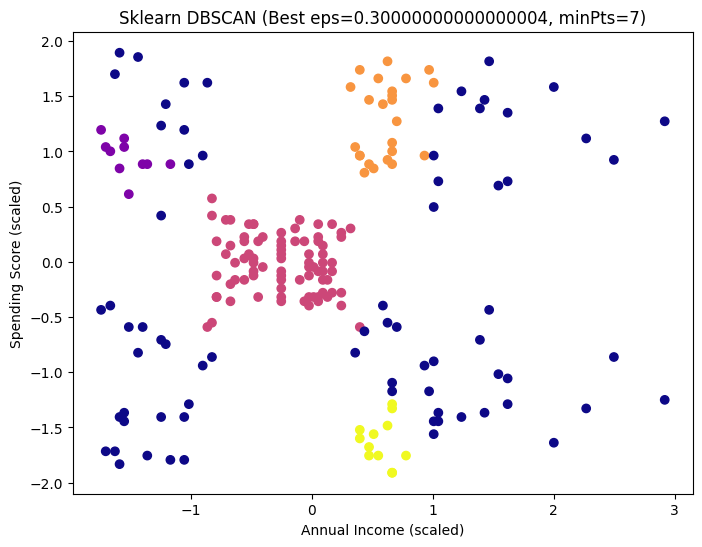

In [61]:
best_model = DBSCAN(eps=best_eps_sklearn, min_samples=best_minpts_sklearn)
best_labels_sklearn = best_model.fit_predict(X_scaled)

mask = best_labels_sklearn != -1
final_score_sklearn = silhouette_score(X_scaled[mask], best_labels_sklearn[mask])

print(f"\n🏆 Final Sklearn DBSCAN → Silhouette Score: {final_score_sklearn:.3f}")

plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=best_labels_sklearn, cmap='plasma')
plt.title(f"Sklearn DBSCAN (Best eps={best_eps_sklearn}, minPts={best_minpts_sklearn})")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.show()

# Plotiing heatmap of Silhouette Scores:

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

def dbscan_silhouette_heatmap(X_scaled, eps_values, minpts_values):
    results = []

    for eps in eps_values:
        for min_pts in minpts_values:
            model = DBSCAN(eps=eps, min_samples=min_pts)
            labels = model.fit_predict(X_scaled)

            mask = labels != -1
            if len(set(labels[mask])) > 1:
                score = silhouette_score(X_scaled[mask], labels[mask])
            else:
                score = np.nan  # not enough clusters

            results.append({'eps': eps, 'minPts': min_pts, 'silhouette': score})
            print(f"eps={eps}, minPts={min_pts} → Silhouette={score}")

    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    pivot_df = results_df.pivot(index='minPts', columns='eps', values='silhouette')

    # Heatmap visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt=".3f")
    plt.title("DBSCAN Silhouette Scores (eps vs minPts)")
    plt.xlabel("Epsilon (eps)")
    plt.ylabel("Minimum Points (minPts)")
    plt.show()

    # Find best parameters
    best_row = results_df.loc[results_df['silhouette'].idxmax()]
    print(f"\n🏆 Best Parameters → eps={best_row['eps']}, minPts={best_row['minPts']}, Silhouette={best_row['silhouette']:.3f}")
    return best_row

eps=0.2, minPts=3 → Silhouette=0.46971271079389654
eps=0.2, minPts=5 → Silhouette=0.5856126991466907
eps=0.2, minPts=7 → Silhouette=0.609411155914858
eps=0.2, minPts=10 → Silhouette=nan
eps=0.30000000000000004, minPts=3 → Silhouette=0.47204049387962216
eps=0.30000000000000004, minPts=5 → Silhouette=0.5243276105881419
eps=0.30000000000000004, minPts=7 → Silhouette=0.6451586733157939
eps=0.30000000000000004, minPts=10 → Silhouette=0.6073013276663172
eps=0.4000000000000001, minPts=3 → Silhouette=0.3953808255515419
eps=0.4000000000000001, minPts=5 → Silhouette=0.4780592455223124
eps=0.4000000000000001, minPts=7 → Silhouette=0.494620783846035
eps=0.4000000000000001, minPts=10 → Silhouette=0.5971952486543135
eps=0.5000000000000001, minPts=3 → Silhouette=0.3892468662417122
eps=0.5000000000000001, minPts=5 → Silhouette=0.3875583892728279
eps=0.5000000000000001, minPts=7 → Silhouette=0.39422828521122516
eps=0.5000000000000001, minPts=10 → Silhouette=0.5106676350237243


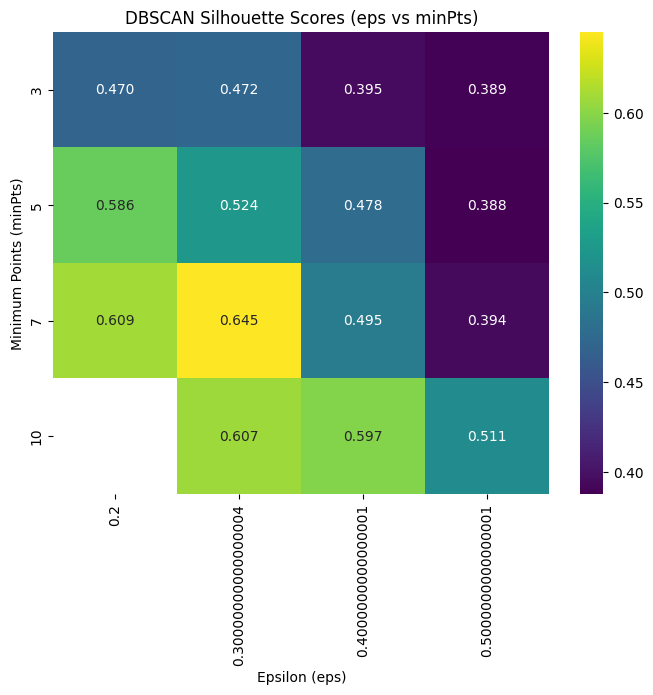


🏆 Best Parameters → eps=0.30000000000000004, minPts=7.0, Silhouette=0.645


In [63]:
eps_range = np.arange(0.2, 0.6, 0.1)
minpts_range = [3, 5, 7, 10]

best_params_df = dbscan_silhouette_heatmap(X_scaled, eps_range, minpts_range)

# Selecting the best Parameters and Train Final model:

In [64]:
best_eps = best_params_df['eps']
best_minpts = best_params_df['minPts']

final_model = DBSCAN(eps=best_eps,min_samples=int(best_minpts))
final_labels = final_model.fit_predict(X_scaled)

mask = final_labels != -1
sil_score_final = silhouette_score(X_scaled[mask], final_labels[mask])


# Visualize the final clusters:

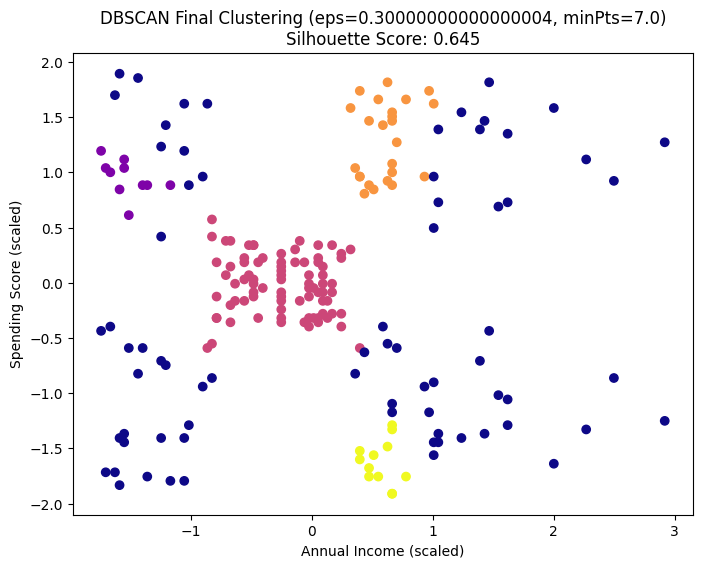

In [65]:

plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=final_labels, cmap='plasma')
plt.title(f"DBSCAN Final Clustering (eps={best_eps}, minPts={best_minpts})\nSilhouette Score: {sil_score_final:.3f}")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.show()

In [66]:
# Hence,we successfully implemented DBSCAN Clustering on Mall Customer Dataset and learnt how this differs from K-Means and Hierarchial Clustering.
# DBSCAN is more useful and effective while the data-points contains irregularities.

# Steps in the DBSCAN Algorithm
#Identify Core Points: For each point in the dataset count the number of points within its eps neighborhood. If the count meets or exceeds MinPts mark the point as a core point.
#Form Clusters: For each core point that is not already assigned to a cluster create a new cluster. Recursively find all density-connected points i.e points within the eps radius of the core point and add them to the cluster.
#Density Connectivity: Two points a and b are density-connected if there exists a chain of points where each point is within the eps radius of the next and at least one point in the chain is a core point. This chaining process ensures that all points in a cluster are connected through a series of dense regions.
#Label Noise Points: After processing all points any point that does not belong to a cluster is labeled as noise.